> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

# 02 - Stationarity

Authored by: [Kian Yang Lee](https://github.com/KianYang-Lee) - kianyang.lee@certifai.ai


## Notebook Description

This tutorial will demonstrate on how to inspect for stationarity and the methods to achieving stationarity. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Understand the fundamentals of stationarity
2. Test for stationarity of time series
3. Achieve time series stationarity through transformation method

## Notebook Outline
Below is the outline for this tutorial:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Stationarity Check](#stationarity-check)<br>
a. [Time Plot](#time-plot)<br>
b. [Autocorrelation Function (ACF) Plot](#acf)<br>
c. [Augmented Dickey-Fuller (ADF) Test](#adf)<br>
4. [Transformation](#transformation)<br>
a. [Differencing](#differencing)<br>
b. [Logarithm Transformation](#log-transform)<br>
c. [Seasonal Differencing](#seasonal-diff)
5. [Exercise](#exercise)
6. [Reference](#reference)
7. [Bonus](#bonus)

## <a name="configuration">Notebook Configurations</a>
Following are the modules that will be used for this tutorial. 

In [1]:
%matplotlib inline

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path

## <a name="dataset">Dataset</a>
The dataset to be used for this tutorial will be generated randomly.

In [2]:
# reproducibility
np.random.seed(38)

# time component
time_steps = np.arange(100)

# moving average data
noise = np.random.normal(loc=0, scale=6.5, size=len(time_steps))
trend = time_steps * 2.75
seasonality = 10 + np.sin(time_steps * 0.25) * 20
generated_data = trend + seasonality + noise

## <a name="stationarity-check">Stationarity Check</a>
A common assumption in many time series models is that the data are stationary.
A stationary time series has a few properties, which are:
1. the mean does not change over time <b>(constant mean)</b>.
2. the variance does not change over time (<b>constant variance</b>).
3. the autocorrelation structure does not change over time (<b>constant autocorrelation structure</b>).

There are a few techniques to inspect for stationarity of a time series, which are:
1. Time plot
2. Autocorrelation Function (ACF) plot
3. Augmented Dickey-Fuller (ADF) test

### <a name="time-plot">Time Plot</a>
Visualization is a great way to inspect the stationarity of time series. We will plot a time plot (also known as run sequence plot) and package it into a function to save the trouble of writing repetitive codes.

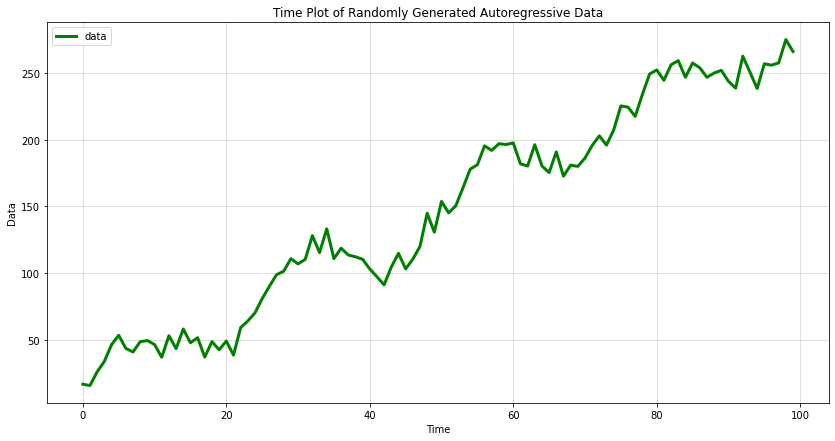

In [3]:
# generate time plot
def generate_time_plot(x1, y1, title="Time Plot", xlabel="Time", ylabel="Data"):
    """
    Display a time plot of x1 versus y1 with the respective x-axis and y-axis labels.
    """
    plt.figure(figsize=(14,7))
    plt.plot(x1, y1, 'k-', label="data", color='green', linewidth=3)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.5)
    plt.legend();
    
generate_time_plot(time_steps, generated_data, title="Time Plot of Randomly Generated Autoregressive Data")

Although this visual shows a definitive proof of non-stationarity for the time series, there are times where the boundaries are not as clear cut. It would be more objective to test it using a statistical technique, which we will introduce now.

### <a name="acf">Autocorrelation Function (ACF) Plot</a>
ACF plot shows the autocorrelation between different lag terms. Correlation values that decrease gradually as the number of lags decrease is a clear indication of a non-stationary time series.

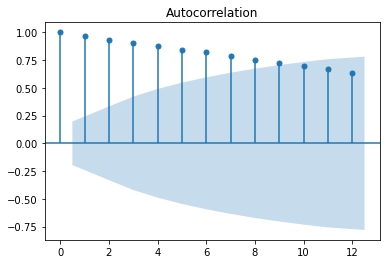

In [4]:
plot_acf(generated_data, lags=12);

### <a name="adf">Augmented Dickey-Fuller Test (ADF)</a>

Augmented Dickey-Fuller test is a statistical technique commonly employed to test for stationarity of time series. Unit roots are a cause for non-stationarity. Being a type of unit root test, ADF Test will determine if a unit root is present.

A time series is considered stationary if a single shift in time doesn’t change the time series statistical properties, in which case unit root does not exist.

The Null and Alternate hypothesis of the Augmented Dickey-Fuller Test is defined as follows:
- Null Hypothesis states there is a presence of a unit root.
- Alternate Hypothesis states there is no unit root present. In other words, stationarity exists.


In [5]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
    

result = adfuller(generated_data, maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -0.628561
P-Value                  0.864397
# Lags Used             11.000000
# Observations Used     88.000000
Critical Value (1%)     -3.506944
Critical Value (5%)     -2.894990
Critical Value (10%)    -2.584615
dtype: float64


A high p-value means that there is a high possibility that non-stationarity is due to chance, and we will reject the assumption that it is stationary. This finding validates what we are expecting, ie. the time series is not stationary.

## <a name="transformation">Transformation</a>
Since stationarity is a desired property for time series modelling, there are a few techniques which we can employ to achieve stationarity. Among them are:
1. Differencing
2. Logarithm transformation
3. Seasonal differencing

### <a name="differencing">Differencing</a>
Differencing is the transformation of the time series by subtracting current value against its lag-1 counterpart, trasnforming it into a new time series with "differenced" values. The equation is as follow:
<br>
<div style="text-align: center;">$Y_t = Z_t − Z_{t−1}$</div>
<br>
As a result, the differenced time series will contain one less point. Usually, it is sufficient for one-time difference (or known as differencing of order-1). If the resulted time series is still not stationary, another round of differencing can be applied.

In [6]:
diff_1_data = generated_data[:-1] - generated_data[1:]
print_adf_result(adfuller(diff_1_data))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -4.109416
P-Value                  0.000934
# Lags Used             10.000000
# Observations Used     88.000000
Critical Value (1%)     -3.506944
Critical Value (5%)     -2.894990
Critical Value (10%)    -2.584615
dtype: float64


Since p-value is lesser than 0.05, we are quite sure that the time series' stationarity is not due to random chance. The alternate hypothesis of non-stationarity for tested time series is accepted. We can inspect the time plot of a non-stationary time series. 

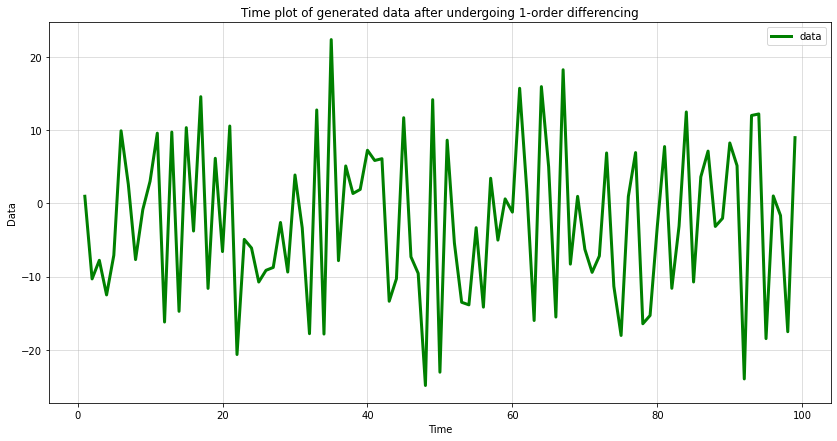

In [7]:
generate_time_plot(time_steps[1:], diff_1_data, 
                   title="Time plot of generated data after undergoing 1-order differencing")

### <a name="log-transform">Logarithm Transformation</a>
Logarithm transformation (or other power transformation) can be applied to transform the time series into a stationary one. Essentially, we can just apply logarithm transformation on each value in the time series to achieve this.

In [8]:
log_data = np.log(generated_data)
print_adf_result(adfuller(log_data))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -1.529906
P-Value                  0.518669
# Lags Used             10.000000
# Observations Used     89.000000
Critical Value (1%)     -3.506057
Critical Value (5%)     -2.894607
Critical Value (10%)    -2.584410
dtype: float64


Since p-value is more than 0.05, we are quite sure that the time series' stationarity is due to random chance. The alternate hypothesis of non-stationarity for tested time series is rejected. Logarithm transformation is not the most popular method in transforming time series into a stationary one, nonetheless one can use it to change the distribution of data. Let's inspect the time plot of this logarithmic transformed time series. 

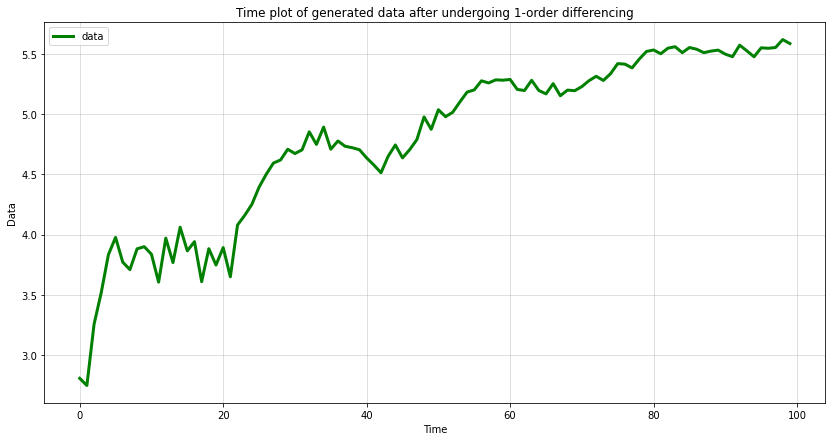

In [9]:
generate_time_plot(time_steps, log_data, 
                   title="Time plot of generated data after undergoing 1-order differencing")

### <a name="seasonal-diff">Seasonal Differencing</a>
Seasonal differencing has the same underlying principles with differencing. The difference is that instead of subtracting the lag-1 term, seasonal differencing operation involves the subtraction of the lag-*n* term of the time series. The <i>n</i> value corresponds to the seasonal period of the series. For example, an annual data would have a *n*-value of 12 since there are 12 months in a year, and a quarterly data would have *n*-value of 4 since there are 4 quarters in a year. Equation is as below:
<br>
<div style="text-align: center;">$Y_t = Z_t − Z_{t−n}$</div>
<br>

In [10]:
# assume that this is an annual data and the seasonal period is n=12
diff_12_data = generated_data[:-12] - generated_data[12:]
print_adf_result(adfuller(diff_12_data))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.573522e+00
P-Value                 2.800474e-11
# Lags Used             1.100000e+01
# Observations Used     7.600000e+01
Critical Value (1%)    -3.519481e+00
Critical Value (5%)    -2.900395e+00
Critical Value (10%)   -2.587498e+00
dtype: float64


Since p-value is lesser than 0.05, we are quite sure that the time series' stationarity is not due to random chance. The alternate hypothesis of non-stationarity for tested time series is accepted. We can inspect the time plot of a non-stationary time series. 

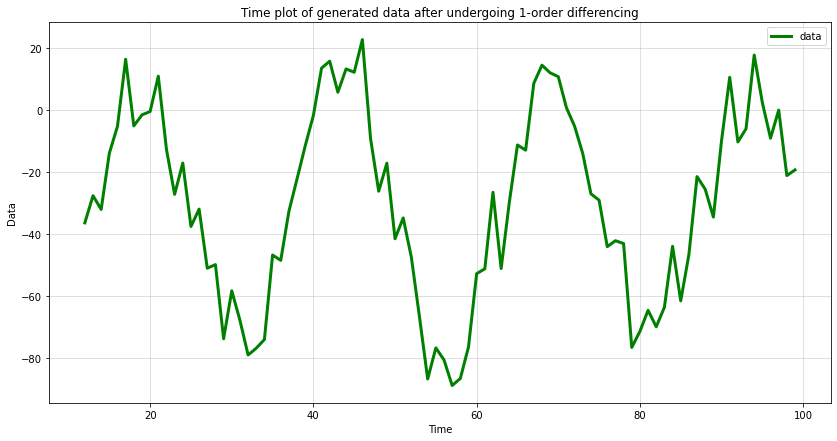

In [11]:
generate_time_plot(time_steps[12:], diff_12_data, 
                   title="Time plot of generated data after undergoing 1-order differencing")

## <a name="exercise">Exercise</a>

This exercise section is attached for you to practice and hone your skills. Try your best effort to complete it without referring to the solution.

### Notebook Configurations
**INSTRUCTIONS**: You can import any module that you wish to use for this exercise. However, if you run the cells from the start of this notebook, most probably all the modules which you need had already been imported at this point.

In [12]:
# import modules
### BEGIN SOLUTION


### END SOLUTION

### Dataset
**INSTRUCTIONS**: Please load the dataset into the environment using the path specified for you.

In [13]:
# specified path
dataset_path = Path().resolve().parent.parent/"datasets/decomposition"
filename = "AirPassengers.csv"

In [14]:
# import dataset using specified path and filename above
### BEGIN SOLUTION
airpassengers = pd.read_csv(dataset_path/Path(filename))

airpassengers_series = pd.Series(airpassengers['#Passengers'].values, 
                            index = pd.date_range('1949-01', periods = len(airpassengers), freq='M'))
### END SOLUTION

### Stationarity Test
**INSTRUCTIONS**: Perform stationarity test on the time series by following the guidelines that are provided in each cell.

Text(0.5, 1.0, 'airpassengers')

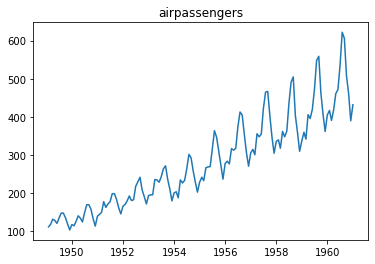

In [15]:
# visualize the time series by plotting a time plot
### BEGIN SOLUTION
plt.plot(airpassengers_series)
plt.title('airpassengers')
### END SOLUTION

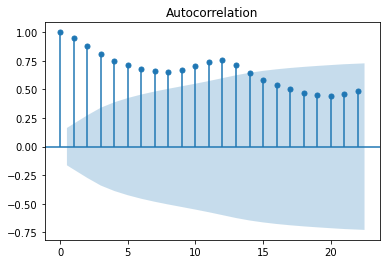

In [16]:
# generate ACF plot
### BEGIN SOLUTION
plot_acf(airpassengers_series);
### END SOLUTION

In [17]:
# ADF Test
### BEGIN SOLUTION
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
    
result = adfuller(airpassengers_series, maxlag=12)
print_adf_result(result)
### END SOLUTION

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        1.564685
P-Value                   0.997748
# Lags Used              12.000000
# Observations Used     131.000000
Critical Value (1%)      -3.481282
Critical Value (5%)      -2.883868
Critical Value (10%)     -2.578677
dtype: float64


### Transformation
**INSTRUCTIONS**: Transform the time series in such a way that stationarity can be achieved.

In [18]:
# transformation
### BEGIN SOLUTION
airpassengers_diff_1 = airpassengers_series.diff()
airpassengers_diff_2 = airpassengers_diff_1[1:].diff()
### END SOLUTION

In [19]:
# check for stationarity using ADF
### BEGIN SOLUTION
diff_1_result = adfuller(airpassengers_diff_1[1:], maxlag=12)
print_adf_result(diff_1_result)

diff_2_result = adfuller(airpassengers_diff_2[1:], maxlag=12)
print_adf_result(diff_2_result)
### END SOLUTION

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.829267
P-Value                   0.054213
# Lags Used              12.000000
# Observations Used     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.638423e+01
P-Value                 2.732892e-29
# Lags Used             1.100000e+01
# Observations Used     1.300000e+02
Critical Value (1%)    -3.481682e+00
Critical Value (5%)    -2.884042e+00
Critical Value (10%)   -2.578770e+00
dtype: float64


Text(0.5, 1.0, 'Differenced time series')

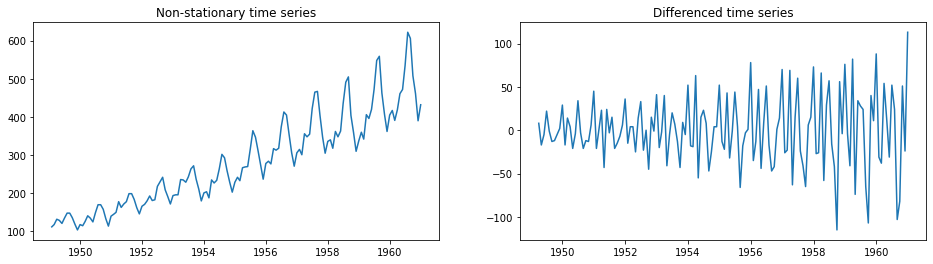

In [20]:
# Plot time plot of differenced time series
### BEGIN SOLUTION
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_series)
ax1.set_title('Non-stationary time series')

ax2.plot(airpassengers_diff_2[1:])
ax2.set_title('Differenced time series')
### END SOLUTION

## <a name="reference">Reference</a>
1. [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)

## <a name="bonus">Bonus</a>
When most professionals talk about stationarity in time series, more common than not it is referring to **weak stationarity**. Yes, you are right. There is actually a **strong stationarity** too! Strong stationarity is the ideal condition to have for a modelling time series, but it is very, very rare in real-world data. That is why when a time series fulfill the conditions for weak stationarity, we consider it as stationary. You can read more about their distinctions [here](https://en.wikipedia.org/wiki/Stationary_process#Strict-sense_stationarity).